In [1]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("DASH_A1.csv")

# Display basic info and preview
df.info(), df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1184 entries, 0 to 1183
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1184 non-null   object 
 1   Close   1159 non-null   float64
 2   High    1160 non-null   float64
 3   Low     1168 non-null   float64
 4   Open    1167 non-null   float64
 5   Volume  1158 non-null   float64
dtypes: float64(5), object(1)
memory usage: 55.6+ KB


(None,
          Date       Close        High         Low        Open     Volume
 0  24-02-2022  100.419998  100.919998   85.177002   86.879997  6639000.0
 1  01-08-2024  108.199997  112.769997  105.905998  108.620003  7965400.0
 2  11-02-2025  193.089996  194.000000  189.500000  190.919998  6771900.0
 3  13-04-2021  149.460007  150.360001  143.550003  146.839996  2823500.0
 4  17-09-2024  129.880005  131.369995  126.900002  131.350006  2825500.0)

In [2]:
# Convert Date column to datetime and sort
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Fill missing Open values with previous day's Close
df['Open'] = df['Open'].fillna(method='ffill')

# Fill missing Close values using forward fill
df['Close'] = df['Close'].fillna(method='ffill')

# Fill missing High/Low with monthly mean
df['Month'] = df['Date'].dt.to_period('M')
df['High'] = df.groupby('Month')['High'].transform(lambda x: x.fillna(x.mean()))
df['Low'] = df.groupby('Month')['Low'].transform(lambda x: x.fillna(x.mean()))

# Fill missing Volume values using conditional rules
volume_median = df['Volume'].median()

def fill_volume(row):
    if pd.notnull(row['Volume']):
        return row['Volume']
    elif row['Open'] == row['Close']:
        return 0
    else:
        return volume_median

df['Volume'] = df.apply(fill_volume, axis=1)

# Drop the helper 'Month' column
df.drop(columns=['Month'], inplace=True)

# Summary of missing values after cleaning
missing_summary = df.isnull().sum()
missing_summary



/tmp/ipykernel_10311/1596726152.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Open'] = df['Open'].fillna(method='ffill')
/tmp/ipykernel_10311/1596726152.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Close'] = df['Close'].fillna(method='ffill')


Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [3]:
# --- Feature Engineering ---

# 1. Simple Daily Returns
df['Simple Return'] = df['Close'].pct_change()

# 2. Logarithmic Returns
df['Log Return'] = np.log(df['Close'] / df['Close'].shift(1))

# 3. 20-Day Momentum
df['20D Momentum'] = df['Close'] - df['Close'].shift(20)

# 4. 20-Day Simple Moving Average
df['20D SMA'] = df['Close'].rolling(window=20).mean()

# 5. 20-Day Rolling Volatility
df['20D Volatility'] = df['Simple Return'].rolling(window=20).std()

# 6. Day of the Week
df['Weekday'] = df['Date'].dt.day_name()

# 7. Price Surge Identification
mean_return = df['Simple Return'].mean()
std_return = df['Simple Return'].std()
df['Price Surge'] = df['Simple Return'] > (mean_return + 4 * std_return)

# 8. Volume Spike Identification
mean_volume = df['Volume'].mean()
std_volume = df['Volume'].std()
df['Volume Spike'] = df['Volume'] > (mean_volume + 6 * std_volume)

# 9. Bollinger Bands
df['Upper Band'] = df['20D SMA'] + 2 * df['20D Volatility']
df['Lower Band'] = df['20D SMA'] - 2 * df['20D Volatility']

df




,Date,Close,High,Low,Open,Volume,Simple Return,Log Return,20D Momentum,20D SMA,20D Volatility,Weekday,Price Surge,Volume Spike,Upper Band,Lower Band
0,2020-12-09,189.509995,195.500000,163.800003,182.000000,25373700.0,NaN,NaN,NaN,NaN,NaN,Wednesday,False,False,NaN,NaN
1,2020-12-10,186.000000,187.695007,172.636002,179.710007,3506800.0,-0.018521,-0.018695,NaN,NaN,NaN,Thursday,False,False,NaN,NaN
2,2020-12-11,175.000000,182.000000,168.250000,176.520004,4760600.0,-0.059140,-0.060961,NaN,NaN,NaN,Friday,False,False,NaN,NaN
3,2020-12-14,160.000000,170.000000,151.199997,169.100006,7859600.0,-0.085714,-0.089612,NaN,NaN,NaN,Monday,False,False,NaN,NaN
4,2020-12-15,158.889999,161.419998,153.759995,157.100006,5017000.0,-0.006938,-0.006962,NaN,NaN,NaN,Tuesday,False,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,2025-06-09,217.490005,219.830002,216.955002,218.029999,2710300.0,-0.004395,-0.004404,33.970001,206.409998,0.017753,Monday,False,False,206.445504,206.374493
1180,2025-06-10,214.970001,219.210007,210.927002,216.589996,3916700.0,-0.011587,-0.011654,22.869995,207.553498,0.015859,Tuesday,False,False,207.585216,207.521780
1181,2025-06-11,217.800003,219.529999,212.240005,214.184998,3091500.0,0.013165,0.013079,20.000000,208.553498,0.014953,Wednesday,False,False,208.583403,208.523593
1182,2025-06-12,216.600006,219.419998,215.675003,218.080002,2510400.0,-0.005510,-0.005525,19.760010,209.541499,0.014976,Thursday,False,False,209.571450,209.511547


In [4]:
# ----- KEY DATES -----
# Extract year
df['Year'] = df['Date'].dt.year

# Define function to extract key dates

def extract_key_dates(group):
    result = {}

    # Highest Volatility
    vol_group = group.dropna(subset=['20D Volatility'])
    if not vol_group.empty:
        result['Highest Volatility Date'] = vol_group.loc[vol_group['20D Volatility'].idxmax(), 'Date']
        result['Highest Volatility Value'] = vol_group['20D Volatility'].max()
    else:
        result['Highest Volatility Date'] = np.nan
        result['Highest Volatility Value'] = np.nan

    # Largest Price Surge
    return_group = group.dropna(subset=['Simple Return'])
    if not return_group.empty:
        result['Largest Price Surge Date'] = return_group.loc[return_group['Simple Return'].idxmax(), 'Date']
        result['Largest Price Surge Value'] = return_group['Simple Return'].max()

        result['Largest Price Drop Date'] = return_group.loc[return_group['Simple Return'].idxmin(), 'Date']
        result['Largest Price Drop Value'] = return_group['Simple Return'].min()
    else:
        result['Largest Price Surge Date'] = result['Largest Price Drop Date'] = np.nan
        result['Largest Price Surge Value'] = result['Largest Price Drop Value'] = np.nan

    # Highest Volume
    volume_group = group.dropna(subset=['Volume'])
    if not volume_group.empty:
        result['Highest Volume Date'] = volume_group.loc[volume_group['Volume'].idxmax(), 'Date']
        result['Highest Volume Value'] = volume_group['Volume'].max()
    else:
        result['Highest Volume Date'] = result['Highest Volume Value'] = np.nan

    # Highest High / Lowest Low
    high_group = group.dropna(subset=['High'])
    low_group = group.dropna(subset=['Low'])
    if not high_group.empty:
        result['Highest High Date'] = high_group.loc[high_group['High'].idxmax(), 'Date']
        result['Highest High Value'] = high_group['High'].max()
    else:
        result['Highest High Date'] = result['Highest High Value'] = np.nan

    if not low_group.empty:
        result['Lowest Low Date'] = low_group.loc[low_group['Low'].idxmin(), 'Date']
        result['Lowest Low Value'] = low_group['Low'].min()
    else:
        result['Lowest Low Date'] = result['Lowest Low Value'] = np.nan

    # Annual Open and Close
    if not group.empty:
        result['Year Open'] = group.iloc[0]['Open']
        result['Year Close'] = group.iloc[-1]['Close']
    else:
        result['Year Open'] = result['Year Close'] = np.nan

    return pd.Series(result)

key_dates_df = df.groupby('Year').apply(extract_key_dates).reset_index()

key_dates_df

/tmp/ipykernel_10311/3850631406.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  key_dates_df = df.groupby('Year').apply(extract_key_dates).reset_index()


,Year,Highest Volatility Date,Highest Volatility Value,Largest Price Surge Date,Largest Price Surge Value,Largest Price Drop Date,Largest Price Drop Value,Highest Volume Date,Highest Volume Value,Highest High Date,Highest High Value,Lowest Low Date,Lowest Low Value,Year Open,Year Close
0,2020,NaT,NaN,2020-12-18,0.078724,2020-12-14,-0.085714,2020-12-09,25373700.0,2020-12-09,195.500000,2020-12-31,135.380005,182.000000,142.750000
1,2021,2021-05-19,0.067188,2021-05-14,0.221491,2021-02-22,-0.135457,2021-03-09,20400000.0,2021-11-15,257.250000,2021-05-13,110.129997,142.500000,148.899994
2,2022,2022-06-01,0.080631,2022-03-16,0.134512,2022-05-11,-0.131621,2022-02-17,47405700.0,2022-01-12,152.494995,2022-10-24,41.365002,149.610001,48.820000
3,2023,2023-02-23,0.047312,2023-11-02,0.156653,2023-02-17,-0.075946,2023-12-15,30556000.0,2023-12-11,103.980003,2023-01-06,45.931999,49.980000,98.889999
4,2024,2024-08-05,0.033216,2024-08-02,0.083457,2024-05-02,-0.103170,2024-05-02,22134800.0,2024-12-17,181.779999,2024-01-04,93.330002,97.800003,167.750000
5,2025,2025-04-24,0.047637,2025-04-09,0.137738,2025-04-03,-0.080634,2025-03-21,73637400.0,2025-06-06,220.880005,2025-04-07,155.399994,168.789993,218.119995


In [5]:
import matplotlib.pyplot as plt


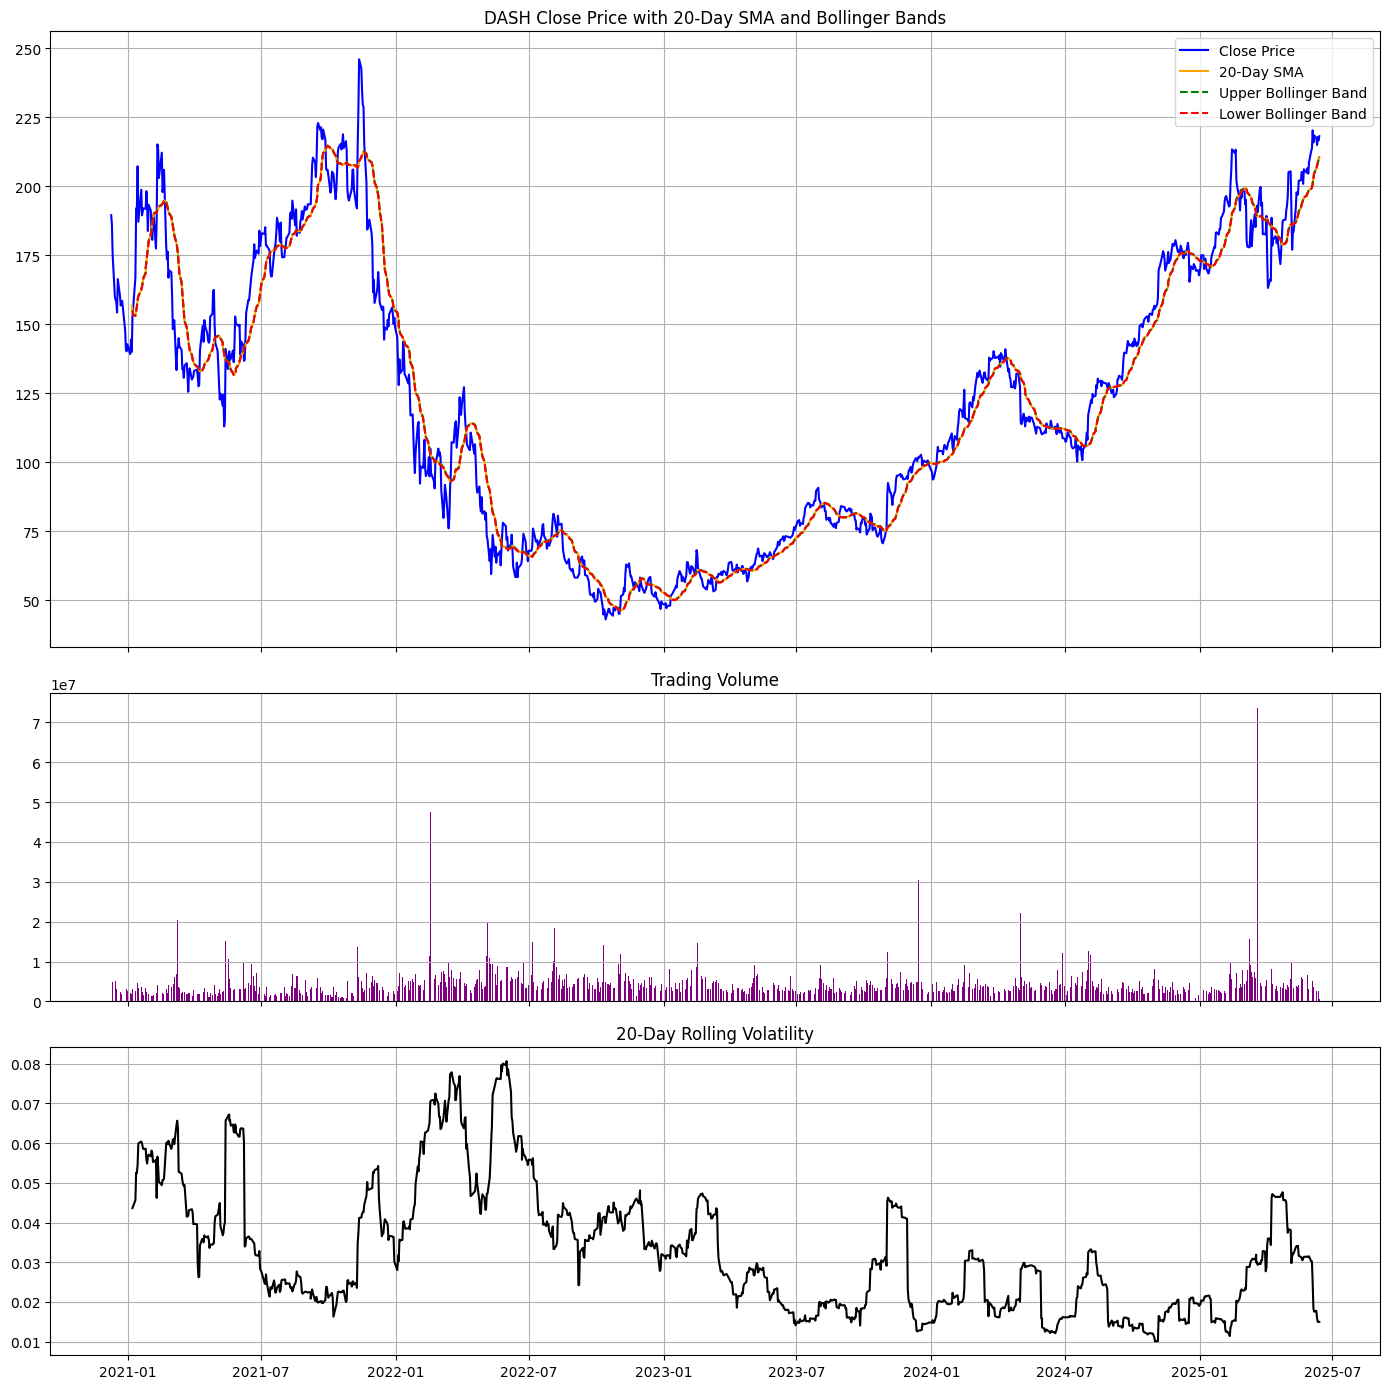

In [6]:
# Set up the figure with 3 rows, 1 column
fig, axs = plt.subplots(3, 1, figsize=(14, 14), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})

# --- Main plot: Close price with SMA and Bollinger Bands ---
axs[0].plot(df["Date"], df["Close"], label="Close Price", color="blue")
axs[0].plot(df["Date"], df["20D SMA"], label="20-Day SMA", color="orange")
axs[0].plot(df["Date"], df["Upper Band"], label="Upper Bollinger Band", color="green", linestyle="--")
axs[0].plot(df["Date"], df["Lower Band"], label="Lower Bollinger Band", color="red", linestyle="--")
axs[0].set_title("DASH Close Price with 20-Day SMA and Bollinger Bands")
axs[0].legend()
axs[0].grid(True)

# --- Subplot 1: Volume ---
axs[1].bar(df["Date"], df["Volume"], color="purple")
axs[1].set_title("Trading Volume")
axs[1].grid(True)

# --- Subplot 2: 20-Day Volatility ---
axs[2].plot(df["Date"], df["20D Volatility"], color="black")
axs[2].set_title("20-Day Rolling Volatility")
axs[2].grid(True)

plt.tight_layout()
plt.show()

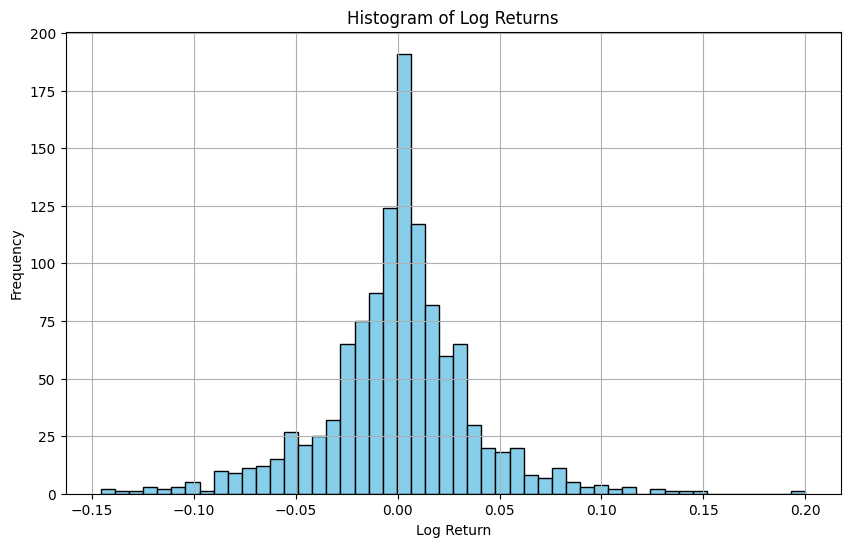

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(df["Log Return"].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

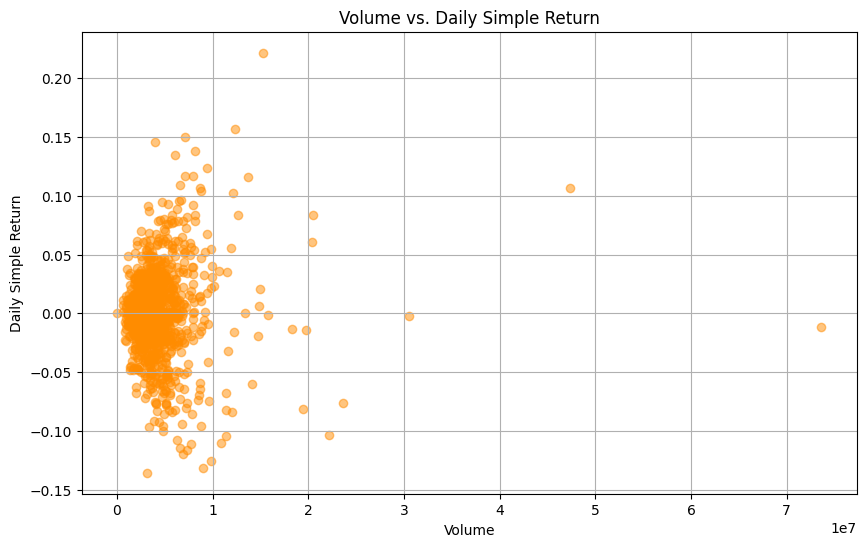

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(df["Volume"], df["Simple Return"], alpha=0.5, color='darkorange')
plt.title("Volume vs. Daily Simple Return")
plt.xlabel("Volume")
plt.ylabel("Daily Simple Return")
plt.grid(True)
plt.show()